In [3]:
import numpy as np
import scipy.stats as stats

# Example sensitivity data for males and females at various FP levels
np.random.seed(42)

fp_rates = [1, 2, 5]  # False positives per image
sensitivity_males = np.random.rand(100, len(fp_rates))  # 100 bootstrap samples for males
sensitivity_females = np.random.rand(100, len(fp_rates))  # 100 bootstrap samples for females

# Function to compute an "AUC" like summary metric
def compute_auc_like_metric(sens, fp_rates):
    auc = np.trapz(sens, fp_rates)
    return auc

# Function to perform bootstrap on overall AUC-like metric
def bootstrap_auc_comparison(sens_males, sens_females, fp_rates, n_bootstrap=1000):
    auc_diffs = []
    
    for i in range(n_bootstrap):
        sample_indices_males = np.random.choice(range(sens_males.shape[0]), size=sens_males.shape[0], replace=True)
        sample_indices_females = np.random.choice(range(sens_females.shape[0]), size=sens_females.shape[0], replace=True)
        
        auc_male = np.mean([compute_auc_like_metric(sens_males[idx], fp_rates) for idx in sample_indices_males])
        auc_female = np.mean([compute_auc_like_metric(sens_females[idx], fp_rates) for idx in sample_indices_females])
        
        auc_diffs.append(auc_male - auc_female)
    
    auc_diffs = np.array(auc_diffs)
    conf_interval = np.percentile(auc_diffs, [2.5, 97.5])
    p_value = stats.wilcoxon(auc_diffs)[1]
    
    return conf_interval, p_value

# Perform bootstrap test on AUC-like metric
conf_interval, p_value_overall = bootstrap_auc_comparison(sensitivity_males, sensitivity_females, fp_rates)

# Print results
print(f"Overall AUC-like metric difference 95% Confidence Interval: {conf_interval}")
print(f"Overall p-value: {p_value_overall}")


Overall AUC-like metric difference 95% Confidence Interval: [-0.24791247  0.19336164]
Overall p-value: 2.589872622196603e-07


In [34]:
# Stats testing for auc
from scipy import stats

male = np.load('/Users/john/Projects/SOTAEvaluationNoduleDetection/workflows/results/summit/grt123/test_balanced/Actionable/FROC/MALE/bootstrap_sensitivites.npy')
female = np.load('/Users/john/Projects/SOTAEvaluationNoduleDetection/workflows/results/summit/grt123/test_balanced/Actionable/FROC/FEMALE/bootstrap_sensitivites.npy')

all_operating_points = np.linspace(0.125, 8, num=10000) 

auc_male_bootstraps = []
auc_female_bootstraps = []
for i in range(1000):

    auc_male_bootstraps.append(np.trapz(male[i,:], x=all_operating_points))
    auc_female_bootstraps.append(np.trapz(female[i,:], x=all_operating_points))

auc_male_bootstraps = np.array(auc_male_bootstraps)
auc_female_bootstraps = np.array(auc_female_bootstraps)

auc_diff_bootstrap = auc_male_bootstraps - auc_female_bootstraps

ci_low, ci_high = np.percentile(auc_diff_bootstrap, [2.5, 97.5])

print(f"Overall AUC-like metric difference 95% Confidence Interval: {ci_low, ci_high}")

t_stat, p_value = stats.ttest_ind(auc_male_bootstraps, auc_female_bootstraps)

print(f"Overall p-value: {p_value:}")
print(f"Overall t-statistic: {t_stat}")


Overall AUC-like metric difference 95% Confidence Interval: (-1.1918390159878687, 0.850163402880351)
Overall p-value: 4.021121955264623e-23
Overall t-statistic: -10.027529935983111


In [35]:
# Stats testing for fixed fp rates and then combined
operating_points = [0.125, 0.25, 0.5, 1, 2, 4, 8]
operating_point_indices = [np.argmin(np.abs(all_operating_points - op)) for op in operating_points]
operating_point_indices

[0, 159, 476, 1111, 2381, 4920, 9999]

In [75]:

import pandas as pd


n_bootstraps = 1000


male_sensitivity = male[:, operating_point_indices]
female_sensitivity = female[:, operating_point_indices]


diff_sens = male_sensitivity - female_sensitivity

print(diff_sens.shape)

mean_diff_sens = np.mean(diff_sens, axis=0)

conf_intervals = np.percentile(diff_sens, [2.5, 97.5], axis=0)

significance = (conf_intervals[0] > 0) | (conf_intervals[1] < 0)

print(f'Mean difference: {mean_diff_sens}')
print(f"Confidence intervals: {conf_intervals}")
print(f"Significance: {significance}")


p_values = []
for i in range(diff_sens.shape[1]):
    differences = diff_sens[:,i]
    t_stat, p_value = stats.ttest_1samp(differences, 0)
    p_values.append(p_value)

p_values = np.array(p_values)

df = pd.DataFrame([p_values], columns=operating_points)

print("P-values")
display(df)


chi2_state = -2 * np.sum(np.log(p_values))

# 2 Degrees of freedom
combined_p_value = 1 - stats.chi2.cdf(chi2_state, 2)

print(f"Combined p-value: {combined_p_value}")

(1000, 7)
Mean difference: [-0.06571735 -0.03656374 -0.06671001 -0.07255737 -0.09681498 -0.01993401
  0.04457345]
Confidence intervals: [[-0.1903374  -0.18894773 -0.22070238 -0.21706263 -0.23826934 -0.16161813
  -0.09056493]
 [ 0.05731206  0.11167818  0.08719193  0.07809457  0.05330694  0.12554967
   0.17805965]]
Significance: [False False False False False False False]
P-values


,0.125,0.250,0.500,1.000,2.000,4.000,8.000
0,7.524938e-160,1.991973e-47,3.698639e-120,8.834322e-143,1.565755e-216,7.635767e-17,7.975688e-81


Combined p-value: 0.0


,counts,cumulative
nodule_counts,,
0.0,1608,1608
1.0,943,2551
2.0,458,3009
3.0,257,3266
4.0,154,3420
5.0,58,3478
6.0,42,3520
7.0,24,3544
8.0,13,3557


,counts,cumulative
nodule_counts,,
0.0,1030,1030
1.0,606,1636
2.0,319,1955
3.0,180,2135
4.0,86,2221
5.0,44,2265
6.0,28,2293
7.0,13,2306
8.0,7,2313


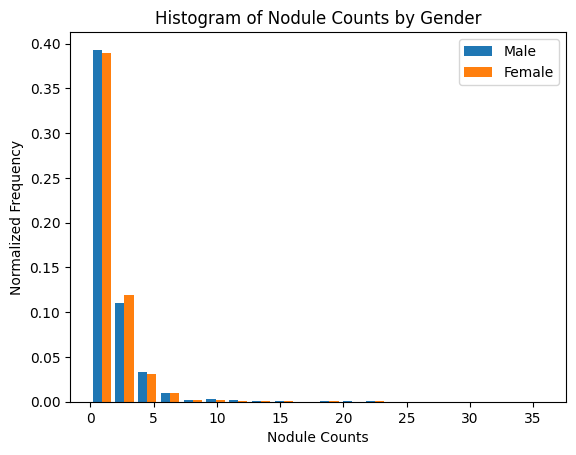

array(['summit-2626-hgp_Y0_BASELINE_A', 'summit-3634-kct_Y0_BASELINE_A',
       'summit-4345-ctj_Y0_BASELINE_A', 'summit-6244-vvj_Y0_BASELINE_A',
       'summit-7347-vgb_Y0_BASELINE_A', 'summit-7658-wmk_Y0_BASELINE_A',
       'summit-8994-kpf_Y0_BASELINE_A'], dtype=object)

gender
MALE      6
FEMALE    1
Name: count, dtype: int64

In [18]:
import pandas as pd
from pathlib import Path
import os

workspace = Path(os.getcwd()).parent


scans_metadata = pd.concat([
    (pd.read_csv(f'{workspace}/metadata/summit/test_balanced/{ds}_scans_metadata.csv', usecols=[
    'LDCT_RADIOLOGY_REPORT_main_participant_id',
    'participant_details_gender',
    'lung_health_check_demographics_race_ethnicgroup'])
    .rename(columns={
    'LDCT_RADIOLOGY_REPORT_main_participant_id': 'participant_id',
    'participant_details_gender' : 'gender',
    'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'
    }).assign(scan_id=lambda df: df['participant_id'] + '_Y0_BASELINE_A', dataset=ds))    
    for ds in ['training', 'validation', 'test']
])


metadata = pd.concat([
    (pd.read_csv(f'{workspace}/metadata/summit/test_balanced/{ds}_metadata.csv')
    .assign(scan_id=lambda df: df['participant_id'] + '_Y0_BASELINE_A'))
    for ds in ['training', 'validation', 'test']
])

nodule_counts = metadata.groupby('scan_id').size().rename('nodule_counts')
combined = pd.merge(scans_metadata, nodule_counts, on='scan_id', how='left').fillna(0)

male_counts = combined[combined['gender'] == 'MALE']['nodule_counts'].value_counts().sort_index()
male_counts_cumsum = male_counts.cumsum()
display(pd.DataFrame({'counts': male_counts, 'cumulative': male_counts_cumsum}))
female_counts = combined[combined['gender'] == 'FEMALE']['nodule_counts'].value_counts().sort_index()
female_counts_cumsum = female_counts.cumsum()
display(pd.DataFrame({'counts': female_counts, 'cumulative': female_counts_cumsum}))


import matplotlib.pyplot as plt

# Histogram of nodule counts
plt.hist([
    combined[combined['gender'] == 'MALE']['nodule_counts'], 
    combined[combined['gender'] == 'FEMALE']['nodule_counts']
],
bins=20,
label=['Male', 'Female'],
density=True
)

plt.xlabel('Nodule Counts')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of Nodule Counts by Gender')
plt.legend()
plt.show()

# 99th quartile value
quartile_97 = combined['nodule_counts'].quantile(0.97)
quartile_97


combined_test = combined[combined['dataset'] == 'test']
display(combined_test[combined_test['nodule_counts'] > quartile_97].scan_id.values)

combined_test[combined_test['nodule_counts'] > quartile_97]['gender'].value_counts()




In [212]:
# Calculate the FPPI for each image - Test Balanced


import pandas as pd
import numpy as np


METADATA_COLUMNS = [
    'name',
    'col',
    'row',
    'index',
    'diameter',
    'management_plan',
    'gender',
    'ethnic_group',
    'nodule_lesion_id',
    'nodule_type'
]

workspace_path = '/Users/john/Projects/SOTAEvaluationNoduleDetection'
flavour = 'test_balanced'
model = 'detection'

if model == 'grt123':
    annotations = pd.read_csv(
        f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/{flavour}/{flavour}_metadata.csv',
        usecols=METADATA_COLUMNS
    )

    results = (
        pd.read_csv(
            f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/{flavour}/{flavour}_predictions.csv',
            usecols=['name', 'col', 'row', 'index', 'diameter', 'threshold']
        )
        .rename(columns={'threshold': 'threshold_original'})
        .assign(threshold=lambda x: 1 / (1 + np.exp(-x['threshold_original'])))
    )
    
elif model == 'detection':
    annotations = pd.read_csv(
        f'{workspace_path}/models/detection/result/trained_summit/summit/{flavour}/annotations.csv',
        usecols=METADATA_COLUMNS
    )
    
    results = pd.read_csv(
        f'{workspace_path}/models/detection/result/trained_summit/summit/{flavour}/predictions.csv',
        usecols=['name', 'col', 'row', 'index', 'diameter', 'threshold']
    )

elif model == 'ticnet':

    _annotations = (
        pd.read_csv(f'/Users/john/Projects/TiCNet-main/annotations/summit/{flavour}/test_metadata.csv').rename(columns={
            'seriesuid' : 'name',
            'coordX' : 'row',
            'coordY' : 'col',
            'coordZ' : 'index',
            'diameter_mm' : 'diameter',
            'probability' : 'threshold'
        })
        .assign(name_counter=lambda df: df.groupby('name').cumcount() + 1)
    )

    _metadata = (
        pd.read_csv(f'/Users/john/Projects/SOTAEvaluationNoduleDetection/metadata/summit/{flavour}/test_metadata.csv')
        .assign(name=lambda df: df.participant_id + '_Y0_BASELINE_A')
        .assign(name_counter=lambda df: df.groupby('name').cumcount() + 1)
    )

    annotations = pd.merge(_metadata, _annotations, on=['name', 'name_counter'], how='outer')[METADATA_COLUMNS]

    assert annotations.shape[0] == _metadata.shape[0], 'Mismatch in number of annotations'

    results = pd.read_csv(f'/Users/john/Projects/TiCNet-main/results/summit/{flavour}/res/110/FROC/submission_rpn.csv').rename(
        columns={
            'seriesuid' : 'name',
            'coordX' : 'row',
            'coordY' : 'col',
            'coordZ' : 'index',
            'diameter_mm' : 'diameter',
            'probability' : 'threshold'
        }
    )




scan_metadata = pd.read_csv(f'{workspace_path}/metadata/summit/{flavour}/test_scans_metadata.csv',
    usecols=['Y0_PARTICIPANT_DETAILS_main_participant_id', 'participant_details_gender','lung_health_check_demographics_race_ethnicgroup']).rename(
    columns={'Y0_PARTICIPANT_DETAILS_main_participant_id': 'StudyId', 'participant_details_gender' : 'gender', 'lung_health_check_demographics_race_ethnicgroup' : 'ethnic_group'}).assign(
    Name=lambda x: x['StudyId'] + '_Y0_BASELINE_A'
)

scan_metadata.head()

number_of_scans = scan_metadata.shape[0]


In [213]:
annotations[annotations['name']=='summit-5253-npq_Y0_BASELINE_A']

,nodule_lesion_id,nodule_type,management_plan,gender,ethnic_group,name,row,col,index,diameter
267,1.0,SOLID,RANDOMISATION_AT_YEAR_1,FEMALE,White,summit-5253-npq_Y0_BASELINE_A,83.07,-4.84,-164.09,5.5
268,2.0,PART_SOLID,3_MONTH_FOLLOW_UP_SCAN,FEMALE,White,summit-5253-npq_Y0_BASELINE_A,-51.26,57.09,-46.53,24.2
269,3.0,SOLID,URGENT_REFERRAL,FEMALE,White,summit-5253-npq_Y0_BASELINE_A,71.97,11.05,-68.93,18.7
270,4.0,PERIFISSURAL,RANDOMISATION_AT_YEAR_1,FEMALE,White,summit-5253-npq_Y0_BASELINE_A,-109.50,2.19,-132.27,13.1
271,6.0,SOLID,URGENT_REFERRAL,FEMALE,White,summit-5253-npq_Y0_BASELINE_A,-76.68,-13.67,-120.00,41.7
272,8.0,SOLID,3_MONTH_FOLLOW_UP_SCAN,FEMALE,White,summit-5253-npq_Y0_BASELINE_A,-54.37,1.49,-125.78,6.9


['Black-MALE' 'Asian or Asian British-MALE' 'White-FEMALE' 'Black-FEMALE'
 'White-MALE' 'Asian or Asian British-FEMALE']


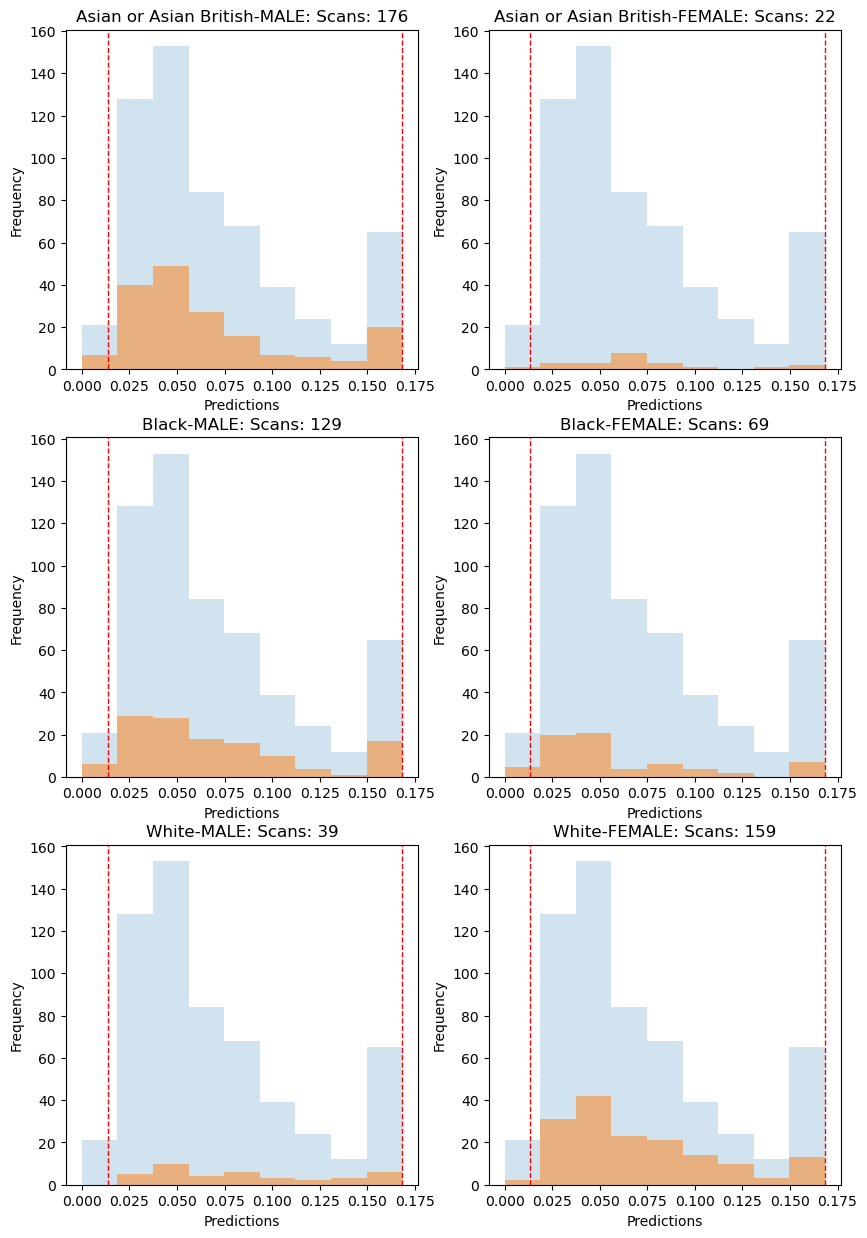

['summit-3888-ppu_Y0_BASELINE_A',
 'summit-4369-evk_Y0_BASELINE_A',
 'summit-5523-qwf_Y0_BASELINE_A',
 'summit-6386-pjp_Y0_BASELINE_A',
 'summit-6875-nym_Y0_BASELINE_A']

In [222]:
# Need to get the thresholds at 0.125, 0.25, 0.5, 1, 2, 4, 8

import math

from matplotlib import pyplot as plt

def scatter_plot_predictions(df):
    df2 = df.copy()
    df2['gender_group'] = df2['ethnic_group'].str.cat(df2['gender'], sep='-')

    fig, ax = plt.subplots(3,2, figsize=(10, 15))
    
    print(df2['gender_group'].unique())


    bins = np.linspace(0, df2['fppi'].max(), 10)

    ax[0,0].hist(df2['fppi'], bins=bins, alpha=0.2)
    ax[0,0].hist(df2[df2['gender_group'] == 'Asian or Asian British-MALE']['fppi'], bins=bins, alpha=0.5)
    ax[0,0].set_title(f"Asian or Asian British-MALE: Scans: {df2[df2['gender_group'] == 'Asian or Asian British-MALE'].shape[0]}")
    ax[0,0].axvline(df2['fppi'].quantile(0.01), color='r', linestyle='dashed', linewidth=1)
    ax[0,0].axvline(df2['fppi'].quantile(0.99), color='r', linestyle='dashed', linewidth=1)

    ax[0,1].hist(df2['fppi'], bins=bins, alpha=0.2)
    ax[0,1].hist(df2[df2['gender_group'] == 'Asian or Asian British-FEMALE']['fppi'], bins=bins, alpha=0.5)
    ax[0,1].set_title(f"Asian or Asian British-FEMALE: Scans: {df2[df2['gender_group'] == 'Asian or Asian British-FEMALE'].shape[0]}")
    ax[0,1].axvline(df2['fppi'].quantile(0.01), color='r', linestyle='dashed', linewidth=1)
    ax[0,1].axvline(df2['fppi'].quantile(0.99), color='r', linestyle='dashed', linewidth=1)

    ax[1,0].hist(df2['fppi'], bins=bins, alpha=0.2)
    ax[1,0].hist(df2[df2['gender_group'] == 'Black-MALE']['fppi'], bins=bins, alpha=0.5)
    ax[1,0].set_title(f"Black-MALE: Scans: {df2[df2['gender_group'] == 'Black-MALE'].shape[0]}")
    ax[1,0].axvline(df2['fppi'].quantile(0.01), color='r', linestyle='dashed', linewidth=1)
    ax[1,0].axvline(df2['fppi'].quantile(0.99), color='r', linestyle='dashed', linewidth=1)

    ax[1,1].hist(df2['fppi'], bins=bins, alpha=0.2)
    ax[1,1].hist(df2[df2['gender_group'] == 'Black-FEMALE']['fppi'], bins=bins, alpha=0.5)
    ax[1,1].set_title(f"Black-FEMALE: Scans: {df2[df2['gender_group'] == 'Black-FEMALE'].shape[0]}")
    ax[1,1].axvline(df2['fppi'].quantile(0.01), color='r', linestyle='dashed', linewidth=1)
    ax[1,1].axvline(df2['fppi'].quantile(0.99), color='r', linestyle='dashed', linewidth=1)

    ax[2,0].hist(df2['fppi'], bins=bins, alpha=0.2)
    ax[2,0].hist(df2[df2['gender_group'] == 'White-MALE']['fppi'], bins=bins, alpha=0.5)
    ax[2,0].set_title(f"White-MALE: Scans: {df2[df2['gender_group'] == 'White-MALE'].shape[0]}")
    ax[2,0].axvline(df2['fppi'].quantile(0.01), color='r', linestyle='dashed', linewidth=1)
    ax[2,0].axvline(df2['fppi'].quantile(0.99), color='r', linestyle='dashed', linewidth=1)

    ax[2,1].hist(df2['fppi'], bins=bins, alpha=0.2)
    ax[2,1].hist(df2[df2['gender_group'] == 'White-FEMALE']['fppi'], bins=bins, alpha=0.5)
    ax[2,1].set_title(f"White-FEMALE: Scans: {df2[df2['gender_group'] == 'White-FEMALE'].shape[0]}")
    ax[2,1].axvline(df2['fppi'].quantile(0.01), color='r', linestyle='dashed', linewidth=1)
    ax[2,1].axvline(df2['fppi'].quantile(0.99), color='r', linestyle='dashed', linewidth=1)

    for i in range(3):
        for j in range(2):
            # ax[i, j].sharex(ax[0, 0])
            # ax[i, j].sharey(ax[0, 0])
            ax[i, j].set_xlabel('Predictions')
            ax[i, j].set_ylabel('Frequency')

    plt.show()

    # Get the cases that are outside of the 1% quantiles
    lower_quantile = df2['fppi'].quantile(0.01)
    upper_quantile = df2['fppi'].quantile(0.99)
    outliers = df2[(df2['fppi'] < lower_quantile) | (df2['fppi'] > upper_quantile)]
    display(outliers.index.to_list())
    
def get_found_nodules(annotations, predictions, threshold):

    predictions_tracker = {idx:False for idx in predictions.index.to_list()}
    annotations_tracker = {idx:False for idx in annotations.index.to_list()}

    for idx, annotation in annotations.iterrows():
        x = float(annotation['col'])
        y = float(annotation['row'])
        z = float(annotation['index'])
        diameter = float(annotation['diameter'])
        if diameter < 0.0:
            diameter = 10.0
        radiusSquared = pow((diameter / 2.0), 2.0)        


        nodule_matches = []
        for jdx, prediction in predictions.iterrows():

            if prediction['threshold'] < threshold:
                continue

            x_pred = float(prediction['col'])
            y_pred = float(prediction['row'])
            z_pred = float(prediction['index'])
            diameter_pred = float(prediction['diameter'])

            dist = math.pow(x - x_pred, 2) + math.pow(y - y_pred, 2) + math.pow(z - z_pred, 2)

            if dist < radiusSquared:
                nodule_matches.append(jdx)
                if predictions_tracker[jdx] == True:
                    # print(f"Warning: {jdx} already found a nodule")
                    pass

                predictions_tracker[jdx] = True

        if len(nodule_matches) > 0:      
            if len(nodule_matches) > 1:
                # print(f"Warning: {len(nodule_matches)} matches found for annotation {idx}")
                pass
            annotations_tracker[idx] = True

    false_positives = sum([1 for idx, found in predictions_tracker.items() if found == False])
    hits = sum([1 for idx, found in annotations_tracker.items() if found == True])
    misses = sum([1 for idx, found in annotations_tracker.items() if found == False])

    return hits, false_positives, misses
    
froc_predictions = pd.read_csv(
    '/Users/john/Projects/SOTAEvaluationNoduleDetection/workflows/results/summit/grt123/test_balanced/All/FROC/all/froc_predictions.txt',
    header=None,
    names=['fps', 'sensitivity', 'threshold']
)

fps_itp = np.linspace(0.125, 8, num=10000)
sens_itp = np.interp(fps_itp, froc_predictions['fps'], froc_predictions['sensitivity'])
thresh_itp = np.interp(fps_itp, froc_predictions['fps'], froc_predictions['threshold'])
indices = [np.argmin(np.abs(fps_itp - fp)) for fp in operating_points]
thresh_itp[indices]

# Calculate the False Positives Per Image for each image at each operating point

fppi = {}
for idx, thresh in enumerate(thresh_itp[indices]):

    fppi_thresh = {}
    for jdx, row in scan_metadata.iterrows():

        scan_id = row['Name']
        scan_results = results[(results['name'] == scan_id)]
        scan_annotations = annotations[annotations['name'] == scan_id]
        hits, false_positives, misses = get_found_nodules(scan_annotations, scan_results, thresh)
        fppi_thresh[scan_id] = {
            'annotations_cnt': len(scan_annotations),
            'predictions_cnt': len(scan_results),
            'hits': hits, 
            'false_positives': false_positives, 
            'misses': misses,
            'gender' : row['gender'],
            'ethnic_group' : row['ethnic_group']
        }

    df = pd.DataFrame.from_dict(fppi_thresh, orient='index') 
    df['fppi'] = df['false_positives'] / number_of_scans
    df['sens'] = df.apply(lambda df: (df['hits'] / (df['hits'] + df['misses'])) if (df['hits'] + df['misses']) > 0 else 1, axis=1)

    fppi_thresh = {
    'data' : df,
    'mean_fppi' : np.mean(df['fppi']),
    'var_fppi' : np.var(df['fppi']),
    'std_fppi' : np.std(df['fppi']),
    'mean_sens' : np.mean(df['sens']),
    'var_sens' : np.var(df['sens']),
    'std_sens' : np.std(df['sens'])
    }

    df.to_csv(f'results/fppi_{operating_points[idx]}.csv')

    scatter_plot_predictions(df)
    break